In [29]:
import glob
import numpy as np
import matplotlib.image as mpimg
import cv2

imgpoints = []
objpoints = []

images = glob.glob('camera_cal/calibration*.jpg')

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

In [30]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [31]:
def undistort_image(img, dist, mtx):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


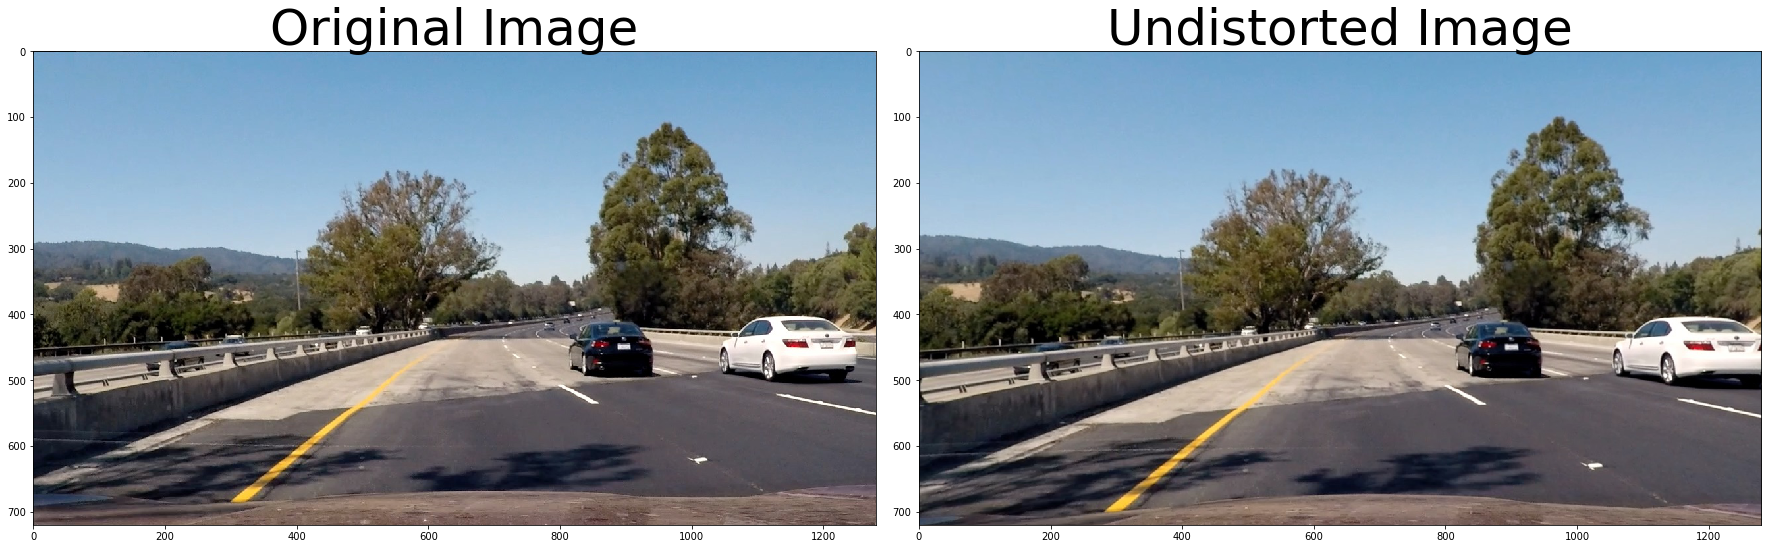

In [95]:
img = mpimg.imread('test_images\\test4.jpg')

import matplotlib.pyplot as plt

%matplotlib inline

undistorted = undistort_image(img, dist, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [68]:
def image_filter(img, thresh_s, thresh_l, thresh_d, mag_thresh, sobel_kernel):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    sobelx = cv2.Sobel(l, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(l, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    grad = np.sqrt(sobelx**2+sobely**2)
    abs_sobel = np.absolute(grad)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary = np.zeros_like(h)
    binary[(s > thresh_s[0]) & (s <= thresh_s[1]) & (l>thresh_l[0]) & (l<=thresh_l[1]) & (scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) & (direction >= thresh_d[0]) & (direction <= thresh_d[1])] = 1
    return binary

In [80]:
def perspective_transform(img, src, dst, image_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    return warped

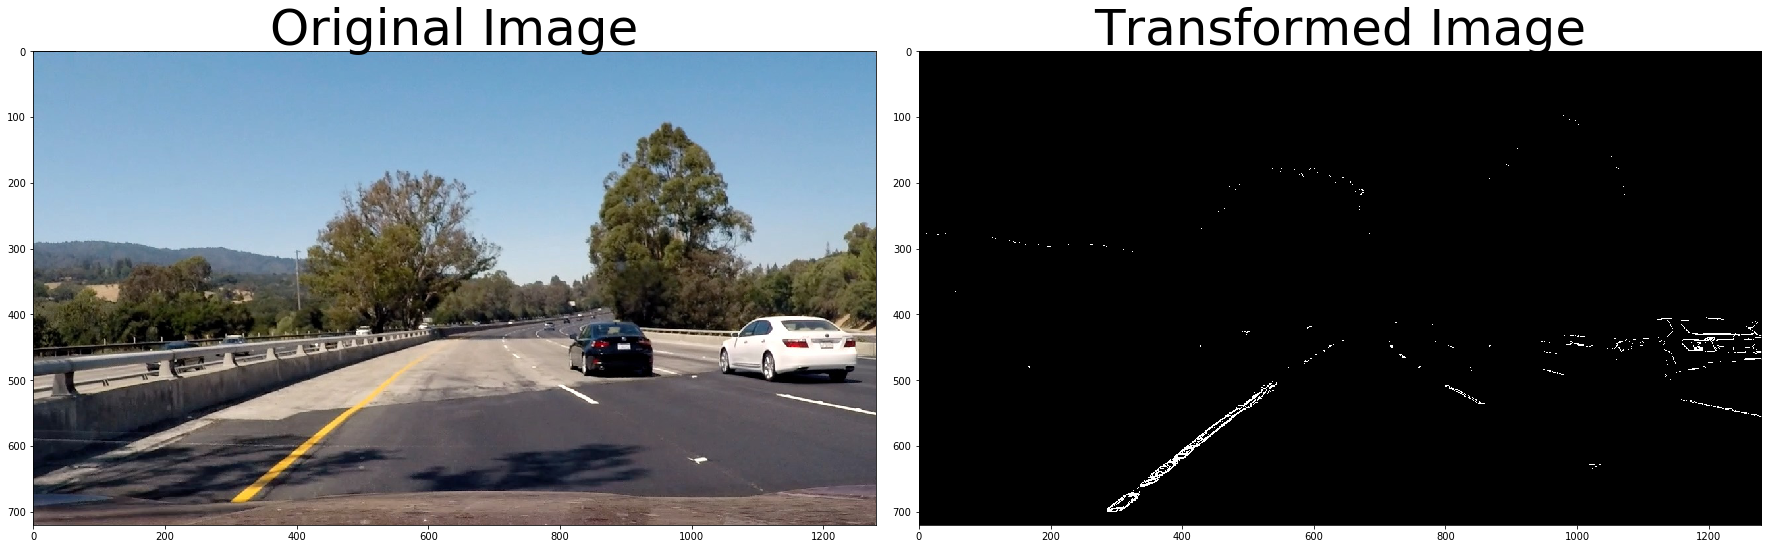

In [96]:

transformed = image_filter(undistorted, (100, 255), (100, 255), (0.3, 1.8), (10, 150), 3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(transformed, cmap='gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

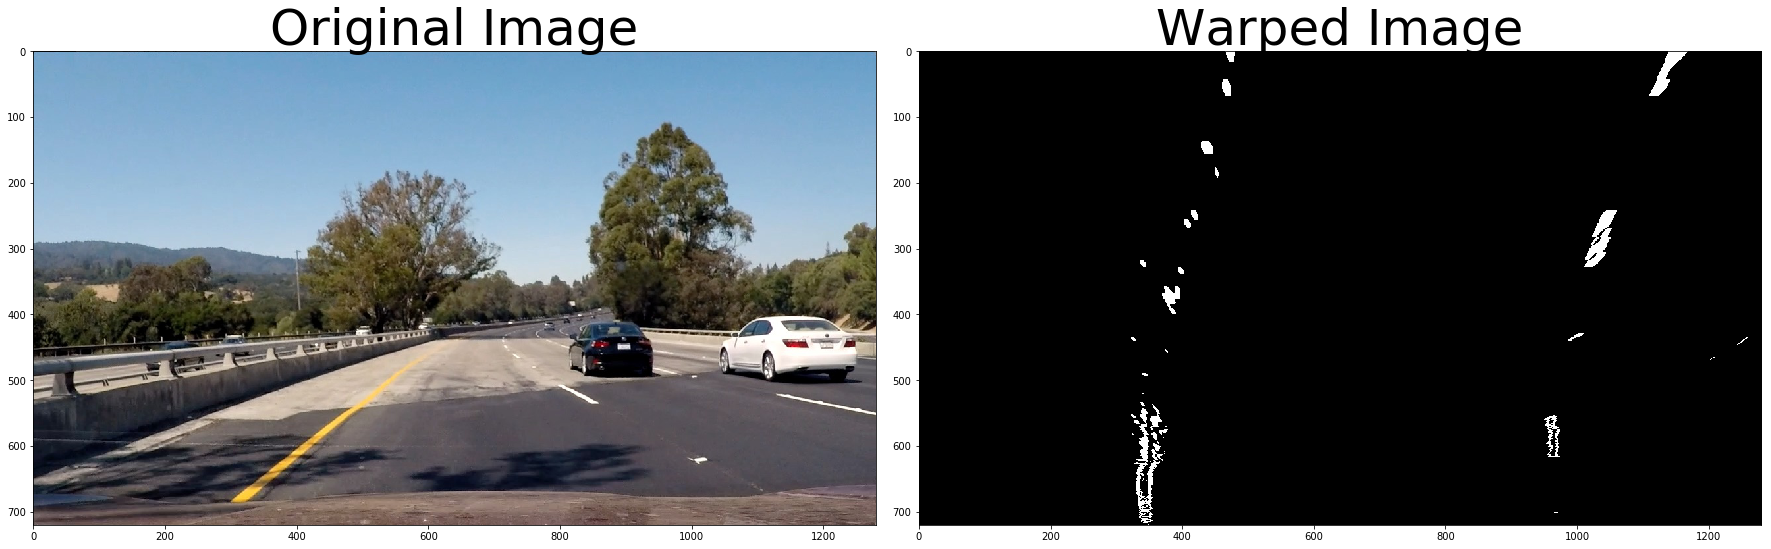

In [97]:
src = np.float32([[270,672], [540, 490], [748,490], [1030,672]])
dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])

warped = perspective_transform(transformed,src, dst, transformed.shape[::-1])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [103]:
def pipeline(image):
    undistorted = undistort_image(image, dist, mtx)
    src = np.float32([[270,672], [540, 490], [748,490], [1030,672]])
    dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])
    transformed = image_filter(undistorted, (100, 255), (100, 255), (0.3, 1.8), (10, 150), 3)
    warped = perspective_transform(transformed,src, dst, transformed.shape[::-1])
    img = np.dstack((warped,warped,warped))*255
    return img.astype(np.uint8)

In [104]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:14<00:00,  5.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 15s
